# Análisis de Hipótesis: Concentración Urbana de Divorcios
## Desigualdad Estructural y Barreras de Acceso a Justicia en Guatemala



**"Existe una concentración desproporcionada de divorcios en el departamento de Guatemala comparada con su proporción de matrimonios, lo que indica barreras estructurales de acceso a justicia para departamentos rurales"**

Esta hipótesis explora si estas barreras crean una **desigualdad geográfica** en el acceso al divorcio legal.


## 1. Configuración Inicial y Carga de Librerías

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

In [2]:
# Cargar datasets
divorcios = pd.read_csv('div_full.csv', encoding='utf-8')
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"✓ Divorcios cargados: {divorcios.shape[0]:,} registros")
print(f"✓ Matrimonios cargados: {matrimonios.shape[0]:,} registros")

✓ Divorcios cargados: 56,349 registros
✓ Matrimonios cargados: 752,264 registros


In [3]:
# Mapeo de departamentos para limpieza
mapeo_departamentos = {
    'Guatemala': 'Guatemala',
    'Quetzaltenango': 'Quetzaltenango',
    'Escuintla': 'Escuintla',
    'Jutiapa': 'Jutiapa',
    'San Marcos': 'San Marcos',
    'Izabal': 'Izabal',
    'Huehuetenango': 'Huehuetenango',
    'Suchitepequez': 'Suchitepéquez',
    'Suchitepéquez': 'Suchitepéquez',
    'Retalhuleu': 'Retalhuleu',
    'Zacapa': 'Zacapa',
    'Santa Rosa': 'Santa Rosa',
    'Chiquimula': 'Chiquimula',
    'Alta Verapaz': 'Alta Verapaz',
    'Jalapa': 'Jalapa',
    'Peten': 'Petén',
    'Petén': 'Petén',
    'Quiche': 'Quiché',
    'Quiché': 'Quiché',
    'Chimaltenango': 'Chimaltenango',
    'Sacatepequez': 'Sacatepéquez',
    'Sacatepéquez': 'Sacatepéquez',
    'Baja Verapaz': 'Baja Verapaz',
    'El Progreso': 'El Progreso',
    'Totonicapan': 'Totonicapán',
    'Totonicapán': 'Totonicapán',
    'Solola': 'Sololá',
    'Sololá': 'Sololá'
}

# Limpiar departamentos
divorcios['DEPREG_LIMPIO'] = divorcios['DEPREG'].map(mapeo_departamentos).fillna(divorcios['DEPREG'])
matrimonios['DEPREG_LIMPIO'] = matrimonios['DEPREG'].map(mapeo_departamentos).fillna(matrimonios['DEPREG'])

# Eliminar registros con departamento faltante
divorcios = divorcios.dropna(subset=['DEPREG_LIMPIO'])
matrimonios = matrimonios.dropna(subset=['DEPREG_LIMPIO'])

print(f"✓ Datos limpios - Divorcios: {len(divorcios):,}")
print(f"✓ Datos limpios - Matrimonios: {len(matrimonios):,}")

✓ Datos limpios - Divorcios: 56,349
✓ Datos limpios - Matrimonios: 752,264


## 3. Análisis de Concentración Geográfica

Calcularemos la proporción de divorcios y matrimonios por departamento para identificar desbalances.

In [4]:
# Contar divorcios y matrimonios por departamento
div_por_depto = divorcios.groupby('DEPREG_LIMPIO').size().reset_index(name='Total_Divorcios')
mat_por_depto = matrimonios.groupby('DEPREG_LIMPIO').size().reset_index(name='Total_Matrimonios')

# Combinar
concentracion = pd.merge(div_por_depto, mat_por_depto, 
                         left_on='DEPREG_LIMPIO', right_on='DEPREG_LIMPIO', how='outer')
concentracion = concentracion.fillna(0)
concentracion.rename(columns={'DEPREG_LIMPIO': 'Departamento'}, inplace=True)

# Calcular porcentajes
concentracion['Pct_Divorcios'] = (concentracion['Total_Divorcios'] / concentracion['Total_Divorcios'].sum()) * 100
concentracion['Pct_Matrimonios'] = (concentracion['Total_Matrimonios'] / concentracion['Total_Matrimonios'].sum()) * 100

# Calcular diferencia (brecha de acceso)
concentracion['Brecha_Acceso'] = concentracion['Pct_Divorcios'] - concentracion['Pct_Matrimonios']

# Calcular tasa de divorcio
concentracion['Tasa_Divorcio'] = (concentracion['Total_Divorcios'] / concentracion['Total_Matrimonios']) * 1000
concentracion['Tasa_Divorcio'] = concentracion['Tasa_Divorcio'].replace([np.inf, -np.inf], 0)

# Ordenar por brecha de acceso
concentracion = concentracion.sort_values('Brecha_Acceso', ascending=False).reset_index(drop=True)

print("✓ Análisis de concentración completado")
print(f"\nTotal de departamentos: {len(concentracion)}")
print("\nTop 5 departamentos por brecha de acceso positiva:")
print(concentracion.head()[['Departamento', 'Pct_Divorcios', 'Pct_Matrimonios', 'Brecha_Acceso']])

✓ Análisis de concentración completado

Total de departamentos: 22

Top 5 departamentos por brecha de acceso positiva:
     Departamento  Pct_Divorcios  Pct_Matrimonios  Brecha_Acceso
0       Guatemala      39.644004        20.831118      18.812887
1  Quetzaltenango       7.409182         6.197558       1.211624
2          Zacapa       2.683277         1.584417       1.098860
3          Izabal       3.231646         2.278854       0.952791
4         Jutiapa       3.989423         3.229185       0.760238


In [5]:
# Análisis específico del departamento de Guatemala
guatemala_data = concentracion[concentracion['Departamento'] == 'Guatemala'].iloc[0]

print("="*70)
print("CONCENTRACIÓN EN DEPARTAMENTO DE GUATEMALA")
print("="*70)
print(f"\nDIVORCIOS:")
print(f"  Total: {guatemala_data['Total_Divorcios']:,.0f}")
print(f"  Porcentaje del país: {guatemala_data['Pct_Divorcios']:.2f}%")

print(f"\nMATRIMONIOS:")
print(f"  Total: {guatemala_data['Total_Matrimonios']:,.0f}")
print(f"  Porcentaje del país: {guatemala_data['Pct_Matrimonios']:.2f}%")

print(f"\nBRECHA DE ACCESO:")
print(f"  Diferencia: {guatemala_data['Brecha_Acceso']:+.2f} puntos porcentuales")
print(f"  Tasa de divorcio: {guatemala_data['Tasa_Divorcio']:.2f} por 1000 matrimonios")

# Calcular ratio de concentración
ratio_concentracion = guatemala_data['Pct_Divorcios'] / guatemala_data['Pct_Matrimonios']
print(f"\nRATIO DE CONCENTRACIÓN:")
print(f"  Guatemala concentra {ratio_concentracion:.2f}x más divorcios que matrimonios")
print(f"  (en relación a su proporción del país)")

CONCENTRACIÓN EN DEPARTAMENTO DE GUATEMALA

DIVORCIOS:
  Total: 22,339
  Porcentaje del país: 39.64%

MATRIMONIOS:
  Total: 156,705
  Porcentaje del país: 20.83%

BRECHA DE ACCESO:
  Diferencia: +18.81 puntos porcentuales
  Tasa de divorcio: 142.55 por 1000 matrimonios

RATIO DE CONCENTRACIÓN:
  Guatemala concentra 1.90x más divorcios que matrimonios
  (en relación a su proporción del país)


## 4. Índices de Desigualdad

Calcularemos índices estadísticos para cuantificar la desigualdad:
- **Índice de Gini** - Mide concentración (0 = equidad perfecta, 1 = concentración total)
- **Índice de Herfindahl-Hirschman (HHI)** - Mide concentración de mercado
- **Coeficiente de Variación** - Mide dispersión relativa

In [6]:
def calcular_gini(valores):
    """
    Calcula el índice de Gini para una serie de valores.
    0 = perfecta igualdad, 1 = perfecta desigualdad
    """
    valores = np.sort(valores)
    n = len(valores)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * valores)) / (n * np.sum(valores)) - (n + 1) / n

def calcular_hhi(porcentajes):
    """
    Calcula el índice Herfindahl-Hirschman.
    Suma de cuadrados de las cuotas de mercado.
    """
    return np.sum(porcentajes ** 2)

# Calcular índices para divorcios
gini_divorcios = calcular_gini(concentracion['Pct_Divorcios'].values)
hhi_divorcios = calcular_hhi(concentracion['Pct_Divorcios'].values)
cv_divorcios = concentracion['Pct_Divorcios'].std() / concentracion['Pct_Divorcios'].mean()

# Calcular índices para matrimonios
gini_matrimonios = calcular_gini(concentracion['Pct_Matrimonios'].values)
hhi_matrimonios = calcular_hhi(concentracion['Pct_Matrimonios'].values)
cv_matrimonios = concentracion['Pct_Matrimonios'].std() / concentracion['Pct_Matrimonios'].mean()

print("="*70)
print("ÍNDICES DE DESIGUALDAD GEOGRÁFICA")
print("="*70)

print("\nDIVORCIOS:")
print(f"  Índice de Gini: {gini_divorcios:.4f}")
print(f"  HHI: {hhi_divorcios:.2f}")
print(f"  Coeficiente de Variación: {cv_divorcios:.4f}")

print("\nMATRIMONIOS:")
print(f"  Índice de Gini: {gini_matrimonios:.4f}")
print(f"  HHI: {hhi_matrimonios:.2f}")
print(f"  Coeficiente de Variación: {cv_matrimonios:.4f}")

print("\nDIFERENCIAS:")
print(f"  Δ Gini: {gini_divorcios - gini_matrimonios:+.4f}")
print(f"  Δ HHI: {hhi_divorcios - hhi_matrimonios:+.2f}")
print(f"  Δ CV: {cv_divorcios - cv_matrimonios:+.4f}")

if gini_divorcios > gini_matrimonios:
    print("\n  ✓ Los divorcios están MÁS CONCENTRADOS que los matrimonios")
else:
    print("\n  ✗ Los divorcios NO están más concentrados que los matrimonios")

ÍNDICES DE DESIGUALDAD GEOGRÁFICA

DIVORCIOS:
  Índice de Gini: 0.4747
  HHI: 1779.69
  Coeficiente de Variación: 1.7476

MATRIMONIOS:
  Índice de Gini: 0.3790
  HHI: 811.26
  Coeficiente de Variación: 0.9067

DIFERENCIAS:
  Δ Gini: +0.0957
  Δ HHI: +968.43
  Δ CV: +0.8409

  ✓ Los divorcios están MÁS CONCENTRADOS que los matrimonios


## 5. Visualización de Concentración Geográfica

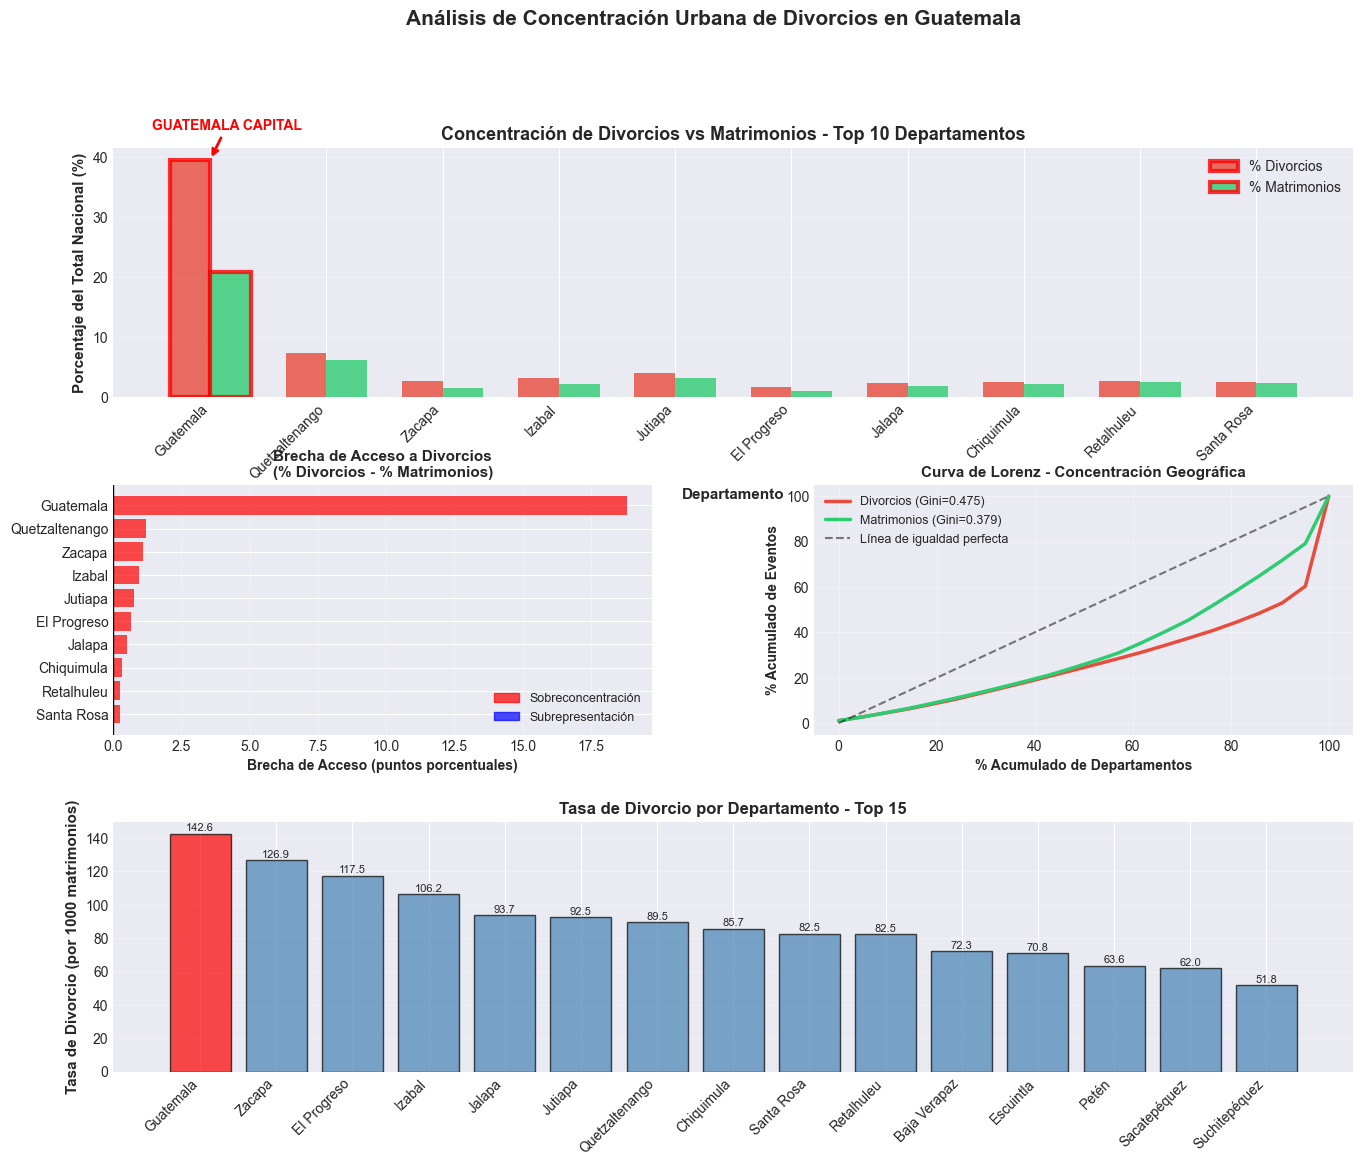

✓ Visualización de concentración generada


In [ ]:
# Crear visualización completa de concentración
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. Gráfico de barras comparativo (Top 10)
ax1 = fig.add_subplot(gs[0, :])
top_10 = concentracion.head(10).copy()
x = np.arange(len(top_10))
width = 0.35

bars1 = ax1.bar(x - width/2, top_10['Pct_Divorcios'], width, 
                label='% Divorcios', alpha=0.8, color='#e74c3c')
bars2 = ax1.bar(x + width/2, top_10['Pct_Matrimonios'], width,
                label='% Matrimonios', alpha=0.8, color='#2ecc71')

# Resaltar Guatemala
guatemala_idx = top_10[top_10['Departamento'] == 'Guatemala'].index[0]
bars1[guatemala_idx].set_edgecolor('red')
bars1[guatemala_idx].set_linewidth(3)
bars2[guatemala_idx].set_edgecolor('red')
bars2[guatemala_idx].set_linewidth(3)

ax1.set_xlabel('Departamento', fontsize=11, fontweight='bold')
ax1.set_ylabel('Porcentaje del Total Nacional (%)', fontsize=11, fontweight='bold')
ax1.set_title('Concentración de Divorcios vs Matrimonios - Top 10 Departamentos', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(top_10['Departamento'], rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(True, axis='y', alpha=0.3)

# Añadir anotación para Guatemala
ax1.annotate('GUATEMALA CAPITAL', 
             xy=(guatemala_idx, top_10.iloc[guatemala_idx]['Pct_Divorcios']),
             xytext=(guatemala_idx-0.5, top_10.iloc[guatemala_idx]['Pct_Divorcios']+5),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, fontweight='bold', color='red')

# 2. Brecha de acceso
ax2 = fig.add_subplot(gs[1, 0])
brecha_sorted = concentracion.sort_values('Brecha_Acceso', ascending=True).tail(10)
colors_brecha = ['red' if x > 0 else 'blue' for x in brecha_sorted['Brecha_Acceso']]

ax2.barh(range(len(brecha_sorted)), brecha_sorted['Brecha_Acceso'], 
         color=colors_brecha, alpha=0.7)
ax2.set_yticks(range(len(brecha_sorted)))
ax2.set_yticklabels(brecha_sorted['Departamento'])
ax2.set_xlabel('Brecha de Acceso (puntos porcentuales)', fontsize=10, fontweight='bold')
ax2.set_title('Brecha de Acceso a Divorcios\n(% Divorcios - % Matrimonios)', 
              fontsize=11, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, axis='x', alpha=0.3)

# Leyenda de colores
red_patch = mpatches.Patch(color='red', alpha=0.7, label='Sobreconcentración')
blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Subrepresentación')
ax2.legend(handles=[red_patch, blue_patch], loc='lower right', fontsize=9)

# 3. Curva de Lorenz
ax3 = fig.add_subplot(gs[1, 1])

# Ordenar y calcular acumulados
div_sorted = np.sort(concentracion['Pct_Divorcios'].values)
mat_sorted = np.sort(concentracion['Pct_Matrimonios'].values)

div_cumsum = np.cumsum(div_sorted) / np.sum(div_sorted) * 100
mat_cumsum = np.cumsum(mat_sorted) / np.sum(mat_sorted) * 100

x_lorenz = np.linspace(0, 100, len(div_cumsum))

ax3.plot(x_lorenz, div_cumsum, linewidth=2.5, label=f'Divorcios (Gini={gini_divorcios:.3f})', color='#e74c3c')
ax3.plot(x_lorenz, mat_cumsum, linewidth=2.5, label=f'Matrimonios (Gini={gini_matrimonios:.3f})', color='#2ecc71')
ax3.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='Línea de igualdad perfecta', alpha=0.5)

ax3.set_xlabel('% Acumulado de Departamentos', fontsize=10, fontweight='bold')
ax3.set_ylabel('% Acumulado de Eventos', fontsize=10, fontweight='bold')
ax3.set_title('Curva de Lorenz - Concentración Geográfica', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Tasa de divorcio por departamento
ax4 = fig.add_subplot(gs[2, :])
tasa_sorted = concentracion.sort_values('Tasa_Divorcio', ascending=False).head(15)

colors_tasa = ['red' if d == 'Guatemala' else 'steelblue' for d in tasa_sorted['Departamento']]
bars = ax4.bar(range(len(tasa_sorted)), tasa_sorted['Tasa_Divorcio'], 
               color=colors_tasa, alpha=0.7, edgecolor='black', linewidth=1)

ax4.set_xticks(range(len(tasa_sorted)))
ax4.set_xticklabels(tasa_sorted['Departamento'], rotation=45, ha='right')
ax4.set_ylabel('Tasa de Divorcio (por 1000 matrimonios)', fontsize=11, fontweight='bold')
ax4.set_title('Tasa de Divorcio por Departamento - Top 15', fontsize=12, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)

# Añadir valores
for i, v in enumerate(tasa_sorted['Tasa_Divorcio']):
    ax4.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Análisis de Concentración Urbana de Divorcios en Guatemala',
             fontsize=15, fontweight='bold', y=0.995)

plt.show()

print("✓ Visualización de concentración generada")

## 6. Clustering por Nivel de Acceso a Justicia

Agruparemos los departamentos según:
- Brecha de acceso (diferencia entre % divorcios y % matrimonios)
- Tasa de divorcio
- Volumen absoluto de divorcios

In [8]:
# Preparar features para clustering
features_acceso = ['Brecha_Acceso', 'Tasa_Divorcio', 'Total_Divorcios']

# Extraer matriz de features
X_acceso = concentracion[features_acceso].values

# Normalizar
scaler_acceso = StandardScaler()
X_acceso_scaled = scaler_acceso.fit_transform(X_acceso)

print(f"✓ Features de acceso normalizadas")
print(f"  Forma: {X_acceso_scaled.shape}")
print(f"  Media: {X_acceso_scaled.mean(axis=0).round(4)}")
print(f"  Desv. Est.: {X_acceso_scaled.std(axis=0).round(4)}")

✓ Features de acceso normalizadas
  Forma: (22, 3)
  Media: [ 0.  0. -0.]
  Desv. Est.: [1. 1. 1.]


In [9]:
# Determinar K óptimo
k_range = range(2, min(8, len(concentracion)))

inertias_acceso = []
silhouette_scores_acceso = []

print("Evaluando diferentes valores de K...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_acceso_scaled)
    
    inertias_acceso.append(kmeans.inertia_)
    silhouette_scores_acceso.append(silhouette_score(X_acceso_scaled, labels))
    
    print(f"  K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_acceso[-1]:.4f}")

print("\n✓ Evaluación completada")

Evaluando diferentes valores de K...
  K=2: Inercia=21.24, Silhouette=0.7818
  K=3: Inercia=5.84, Silhouette=0.5715
  K=4: Inercia=2.89, Silhouette=0.5229
  K=5: Inercia=1.63, Silhouette=0.4972
  K=6: Inercia=1.32, Silhouette=0.4821
  K=7: Inercia=0.96, Silhouette=0.4067

✓ Evaluación completada


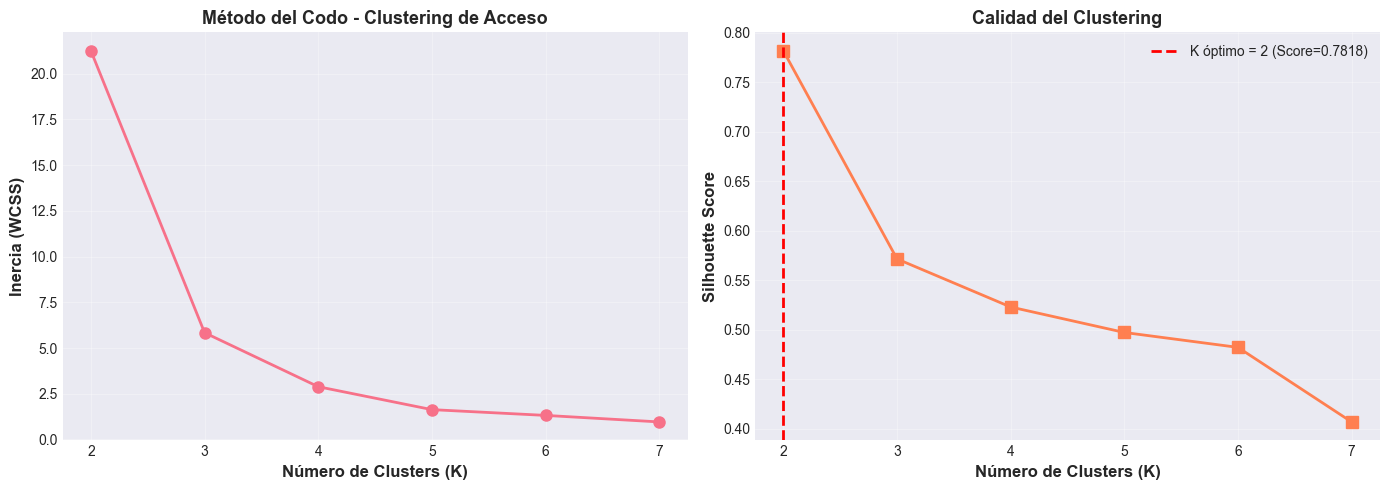


K ÓPTIMO SELECCIONADO: 2
Silhouette Score: 0.7818


In [ ]:
# Visualizar método del codo y silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del Codo
axes[0].plot(list(k_range), inertias_acceso, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12, fontweight='bold')
axes[0].set_title('Método del Codo - Clustering de Acceso', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(k_range))

# Silhouette Score
axes[1].plot(list(k_range), silhouette_scores_acceso, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Calidad del Clustering', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(k_range))

# Marcar K óptimo
best_k_acceso = list(k_range)[np.argmax(silhouette_scores_acceso)]
best_silhouette_acceso = max(silhouette_scores_acceso)
axes[1].axvline(x=best_k_acceso, color='red', linestyle='--', linewidth=2,
                label=f'K óptimo = {best_k_acceso} (Score={best_silhouette_acceso:.4f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"K ÓPTIMO SELECCIONADO: {best_k_acceso}")
print(f"Silhouette Score: {best_silhouette_acceso:.4f}")
print(f"{'='*60}")

In [11]:
# Aplicar K-Means con K óptimo
kmeans_acceso_final = KMeans(n_clusters=best_k_acceso, random_state=42, n_init=20)
concentracion['Cluster'] = kmeans_acceso_final.fit_predict(X_acceso_scaled)

# Calcular silhouette score final
silhouette_avg_acceso = silhouette_score(X_acceso_scaled, concentracion['Cluster'])

print(f"✓ Clustering aplicado con K={best_k_acceso}")
print(f"  Silhouette Score: {silhouette_avg_acceso:.4f}")
print(f"\nDistribución de departamentos por cluster:")
print(concentracion['Cluster'].value_counts().sort_index())

✓ Clustering aplicado con K=2
  Silhouette Score: 0.7818

Distribución de departamentos por cluster:
Cluster
0    21
1     1
Name: count, dtype: int64


## 7. Interpretación de Clusters de Acceso

In [12]:
# Estadísticas por cluster
cluster_stats_acceso = concentracion.groupby('Cluster').agg({
    'Departamento': 'count',
    'Brecha_Acceso': ['mean', 'std'],
    'Tasa_Divorcio': ['mean', 'std'],
    'Total_Divorcios': ['sum', 'mean'],
    'Total_Matrimonios': ['sum', 'mean']
}).round(2)

print("ESTADÍSTICAS POR CLUSTER (NIVEL DE ACCESO)")
print("="*80)
print(cluster_stats_acceso)
print("\n")

# Departamentos en cada cluster
for cluster_id in sorted(concentracion['Cluster'].unique()):
    deptos = concentracion[concentracion['Cluster'] == cluster_id]['Departamento'].tolist()
    brecha_avg = concentracion[concentracion['Cluster'] == cluster_id]['Brecha_Acceso'].mean()
    print(f"CLUSTER {cluster_id}: {len(deptos)} departamentos (Brecha promedio: {brecha_avg:+.2f})")
    print(f"  {', '.join(sorted(deptos))}")
    print()

ESTADÍSTICAS POR CLUSTER (NIVEL DE ACCESO)
        Departamento Brecha_Acceso       Tasa_Divorcio        Total_Divorcios  \
               count          mean   std          mean    std             sum   
Cluster                                                                         
0                 21         -0.90  1.85         67.77  31.05           34010   
1                  1         18.81   NaN        142.55    NaN           22339   

                  Total_Matrimonios             
             mean               sum       mean  
Cluster                                         
0         1619.52            595559   28359.95  
1        22339.00            156705  156705.00  


CLUSTER 0: 21 departamentos (Brecha promedio: -0.90)
  Alta Verapaz, Baja Verapaz, Chimaltenango, Chiquimula, El Progreso, Escuintla, Huehuetenango, Izabal, Jalapa, Jutiapa, Petén, Quetzaltenango, Quiché, Retalhuleu, Sacatepéquez, San Marcos, Santa Rosa, Sololá, Suchitepéquez, Totonicapán, Zacapa

CLUST

In [ ]:
# Asignar nombres interpretativos
cluster_characteristics_acceso = []

for cluster_id in sorted(concentracion['Cluster'].unique()):
    cluster_data = concentracion[concentracion['Cluster'] == cluster_id]
    
    brecha_avg = cluster_data['Brecha_Acceso'].mean()
    volumen_avg = cluster_data['Total_Divorcios'].mean()
    
    cluster_characteristics_acceso.append({
        'cluster_id': cluster_id,
        'brecha': brecha_avg,
        'volumen': volumen_avg
    })

# Ordenar por brecha
cluster_characteristics_acceso.sort(key=lambda x: x['brecha'], reverse=True)

# Asignar nombres
cluster_names_acceso = {}
if len(cluster_characteristics_acceso) == 2:
    cluster_names_acceso[cluster_characteristics_acceso[0]['cluster_id']] = 'Alto Acceso (Urbano)'
    cluster_names_acceso[cluster_characteristics_acceso[1]['cluster_id']] = 'Bajo Acceso (Rural)'
elif len(cluster_characteristics_acceso) == 3:
    cluster_names_acceso[cluster_characteristics_acceso[0]['cluster_id']] = 'Alto Acceso (Metropolitano)'
    cluster_names_acceso[cluster_characteristics_acceso[1]['cluster_id']] = 'Acceso Medio (Semi-urbano)'
    cluster_names_acceso[cluster_characteristics_acceso[2]['cluster_id']] = 'Bajo Acceso (Rural)'
elif len(cluster_characteristics_acceso) == 4:
    cluster_names_acceso[cluster_characteristics_acceso[0]['cluster_id']] = 'Acceso Muy Alto'
    cluster_names_acceso[cluster_characteristics_acceso[1]['cluster_id']] = 'Acceso Alto'
    cluster_names_acceso[cluster_characteristics_acceso[2]['cluster_id']] = 'Acceso Medio'
    cluster_names_acceso[cluster_characteristics_acceso[3]['cluster_id']] = 'Acceso Bajo'
else:
    for i, char in enumerate(cluster_characteristics_acceso):
        cluster_names_acceso[char['cluster_id']] = f'Nivel {i+1}'

concentracion['Cluster_Nombre'] = concentracion['Cluster'].map(cluster_names_acceso)

print("CLUSTERS IDENTIFICADOS (Nivel de Acceso a Justicia):")
print("="*70)
for char in cluster_characteristics_acceso:
    cid = char['cluster_id']
    print(f"\n{cluster_names_acceso[cid]}:")
    print(f"  Brecha promedio: {char['brecha']:+.2f} puntos porcentuales")
    print(f"  Volumen promedio: {char['volumen']:.0f} divorcios")
    
    # Verificar si Guatemala está en este cluster
    if 'Guatemala' in concentracion[concentracion['Cluster'] == cid]['Departamento'].values:
        print(f"  Incluye: GUATEMALA CAPITAL")

CLUSTERS IDENTIFICADOS (Nivel de Acceso a Justicia):

Alto Acceso (Urbano):
  Brecha promedio: +18.81 puntos porcentuales
  Volumen promedio: 22339 divorcios
  ⭐ Incluye: GUATEMALA CAPITAL

Bajo Acceso (Rural):
  Brecha promedio: -0.90 puntos porcentuales
  Volumen promedio: 1620 divorcios


## 8. Visualización de Clusters de Acceso

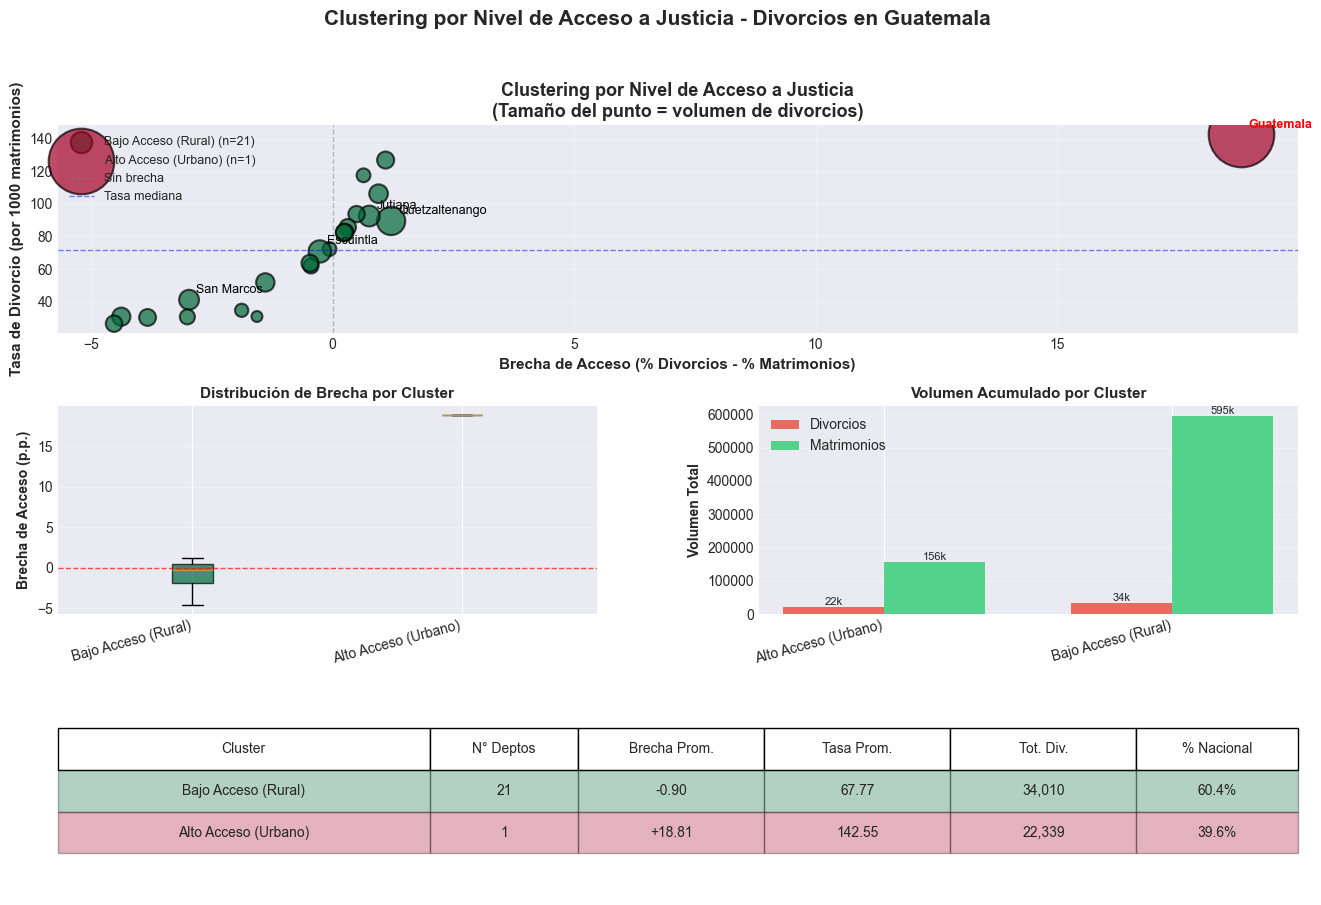

✓ Visualización de clusters generada


In [ ]:
# Crear visualización de clusters
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Colores por cluster
colors_cluster = plt.cm.RdYlGn_r(np.linspace(0, 1, best_k_acceso))
cluster_colors_acceso = {i: colors_cluster[i] for i in range(best_k_acceso)}

# 1. Scatter 3D proyectado: Brecha vs Tasa
ax1 = fig.add_subplot(gs[0, :])
for cluster_id in sorted(concentracion['Cluster'].unique()):
    cluster_data = concentracion[concentracion['Cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['Brecha_Acceso'],
        cluster_data['Tasa_Divorcio'],
        s=cluster_data['Total_Divorcios'] / 10,  # Tamaño proporcional al volumen
        c=[cluster_colors_acceso[cluster_id]],
        label=f"{cluster_names_acceso[cluster_id]} (n={len(cluster_data)})",
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5
    )
    
    # Anotar Guatemala y otros departamentos clave
    for idx, row in cluster_data.iterrows():
        if row['Departamento'] == 'Guatemala' or row['Total_Divorcios'] > 2000:
            ax1.annotate(
                row['Departamento'],
                (row['Brecha_Acceso'], row['Tasa_Divorcio']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold' if row['Departamento'] == 'Guatemala' else 'normal',
                color='red' if row['Departamento'] == 'Guatemala' else 'black'
            )

# Líneas de referencia
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Sin brecha')
ax1.axhline(y=concentracion['Tasa_Divorcio'].median(), color='blue', 
            linestyle='--', linewidth=1, alpha=0.5, label='Tasa mediana')

ax1.set_xlabel('Brecha de Acceso (% Divorcios - % Matrimonios)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Tasa de Divorcio (por 1000 matrimonios)', fontsize=11, fontweight='bold')
ax1.set_title('Clustering por Nivel de Acceso a Justicia\n(Tamaño del punto = volumen de divorcios)', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Distribución de brecha por cluster
ax2 = fig.add_subplot(gs[1, 0])
cluster_brechas = [concentracion[concentracion['Cluster']==c]['Brecha_Acceso'].values 
                   for c in sorted(concentracion['Cluster'].unique())]
bp = ax2.boxplot(cluster_brechas, 
                 labels=[cluster_names_acceso[c] for c in sorted(concentracion['Cluster'].unique())],
                 patch_artist=True)

for patch, cluster_id in zip(bp['boxes'], sorted(concentracion['Cluster'].unique())):
    patch.set_facecolor(cluster_colors_acceso[cluster_id])
    patch.set_alpha(0.7)

ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax2.set_ylabel('Brecha de Acceso (p.p.)', fontsize=10, fontweight='bold')
ax2.set_title('Distribución de Brecha por Cluster', fontsize=11, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3. Volumen total por cluster
ax3 = fig.add_subplot(gs[1, 1])
cluster_volumes = concentracion.groupby('Cluster_Nombre').agg({
    'Total_Divorcios': 'sum',
    'Total_Matrimonios': 'sum'
})

x_pos = np.arange(len(cluster_volumes))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, cluster_volumes['Total_Divorcios'], width,
                label='Divorcios', alpha=0.8, color='#e74c3c')
bars2 = ax3.bar(x_pos + width/2, cluster_volumes['Total_Matrimonios'], width,
                label='Matrimonios', alpha=0.8, color='#2ecc71')

ax3.set_xticks(x_pos)
ax3.set_xticklabels(cluster_volumes.index, rotation=15, ha='right')
ax3.set_ylabel('Volumen Total', fontsize=10, fontweight='bold')
ax3.set_title('Volumen Acumulado por Cluster', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, axis='y', alpha=0.3)

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height/1000)}k' if height >= 1000 else f'{int(height)}',
                ha='center', va='bottom', fontsize=8)

# 4. Tabla resumen
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('tight')
ax4.axis('off')

summary_data = []
for cluster_id in sorted(concentracion['Cluster'].unique()):
    cluster_data = concentracion[concentracion['Cluster'] == cluster_id]
    summary_data.append([
        cluster_names_acceso[cluster_id],
        len(cluster_data),
        f"{cluster_data['Brecha_Acceso'].mean():+.2f}",
        f"{cluster_data['Tasa_Divorcio'].mean():.2f}",
        f"{cluster_data['Total_Divorcios'].sum():,}",
        f"{cluster_data['Pct_Divorcios'].sum():.1f}%"
    ])

table = ax4.table(
    cellText=summary_data,
    colLabels=['Cluster', 'N° Deptos', 'Brecha Prom.', 'Tasa Prom.', 'Tot. Div.', '% Nacional'],
    cellLoc='center',
    loc='center',
    colWidths=[0.30, 0.12, 0.15, 0.15, 0.15, 0.13]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear filas
for i, cluster_id in enumerate(sorted(concentracion['Cluster'].unique())):
    for j in range(6):
        table[(i+1, j)].set_facecolor(cluster_colors_acceso[cluster_id])
        table[(i+1, j)].set_alpha(0.3)

plt.suptitle('Clustering por Nivel de Acceso a Justicia - Divorcios en Guatemala',
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("✓ Visualización de clusters generada")

## 9. Análisis de Brecha Urbano-Rural

Compararemos departamentos urbanos vs rurales para cuantificar la desigualdad estructural.

In [15]:
# Clasificar departamentos como urbanos o rurales
# Urbanos: Alta densidad poblacional y desarrollo económico
urbanos = ['Guatemala', 'Sacatepéquez', 'Quetzaltenango', 'Escuintla']
semi_urbanos = ['Izabal', 'Retalhuleu', 'Santa Rosa', 'Chimaltenango', 'Suchitepéquez']

def clasificar_tipo(depto):
    if depto in urbanos:
        return 'Urbano'
    elif depto in semi_urbanos:
        return 'Semi-urbano'
    else:
        return 'Rural'

concentracion['Tipo'] = concentracion['Departamento'].apply(clasificar_tipo)

# Calcular estadísticas por tipo
tipo_stats = concentracion.groupby('Tipo').agg({
    'Departamento': 'count',
    'Total_Divorcios': 'sum',
    'Total_Matrimonios': 'sum',
    'Pct_Divorcios': 'sum',
    'Pct_Matrimonios': 'sum',
    'Brecha_Acceso': 'mean',
    'Tasa_Divorcio': 'mean'
}).round(2)

print("="*70)
print("ANÁLISIS URBANO-RURAL")
print("="*70)
print(tipo_stats)
print("\n")

# Calcular brechas
print("BRECHAS URBANO-RURAL:")
print("="*70)

if 'Urbano' in tipo_stats.index and 'Rural' in tipo_stats.index:
    brecha_divorcios_ur = tipo_stats.loc['Urbano', 'Pct_Divorcios'] - tipo_stats.loc['Rural', 'Pct_Divorcios']
    brecha_matrimonios_ur = tipo_stats.loc['Urbano', 'Pct_Matrimonios'] - tipo_stats.loc['Rural', 'Pct_Matrimonios']
    brecha_tasa_ur = tipo_stats.loc['Urbano', 'Tasa_Divorcio'] - tipo_stats.loc['Rural', 'Tasa_Divorcio']
    
    print(f"\nPorcentaje de divorcios:")
    print(f"  Urbano: {tipo_stats.loc['Urbano', 'Pct_Divorcios']:.2f}%")
    print(f"  Rural: {tipo_stats.loc['Rural', 'Pct_Divorcios']:.2f}%")
    print(f"  Brecha: {brecha_divorcios_ur:+.2f} puntos porcentuales")
    
    print(f"\nPorcentaje de matrimonios:")
    print(f"  Urbano: {tipo_stats.loc['Urbano', 'Pct_Matrimonios']:.2f}%")
    print(f"  Rural: {tipo_stats.loc['Rural', 'Pct_Matrimonios']:.2f}%")
    print(f"  Brecha: {brecha_matrimonios_ur:+.2f} puntos porcentuales")
    
    print(f"\nTasa de divorcio:")
    print(f"  Urbano: {tipo_stats.loc['Urbano', 'Tasa_Divorcio']:.2f}")
    print(f"  Rural: {tipo_stats.loc['Rural', 'Tasa_Divorcio']:.2f}")
    print(f"  Brecha: {brecha_tasa_ur:+.2f} divorcios por 1000 matrimonios")
    
    print(f"\n{'='*70}")
    print("INTERPRETACIÓN:")
    if brecha_divorcios_ur > brecha_matrimonios_ur:
        print("✓ Los departamentos urbanos concentran PROPORCIONALMENTE MÁS divorcios")
        print("  que matrimonios, indicando mejor acceso a justicia.")
    else:
        print("✗ No se observa concentración diferencial urbano-rural.")

ANÁLISIS URBANO-RURAL
             Departamento  Total_Divorcios  Total_Matrimonios  Pct_Divorcios  \
Tipo                                                                           
Rural                  13            18237             366564          32.36   
Semi-urbano             5             7795             126251          13.83   
Urbano                  4            30317             259449          53.80   

             Pct_Matrimonios  Brecha_Acceso  Tasa_Divorcio  
Tipo                                                        
Rural                  48.73          -1.26          65.15  
Semi-urbano            16.78          -0.59          70.76  
Urbano                 34.49           4.83          91.23  


BRECHAS URBANO-RURAL:

Porcentaje de divorcios:
  Urbano: 53.80%
  Rural: 32.36%
  Brecha: +21.44 puntos porcentuales

Porcentaje de matrimonios:
  Urbano: 34.49%
  Rural: 48.73%
  Brecha: -14.24 puntos porcentuales

Tasa de divorcio:
  Urbano: 91.23
  Rural: 65.15
  Br

## 10. Validación de Hipótesis

**Hipótesis:** Existe una concentración desproporcionada de divorcios en Guatemala capital comparada con su proporción de matrimonios, indicando barreras de acceso a justicia.

### Criterios de validación:
1. Guatemala tiene brecha de acceso positiva y significativa
2. Índice de Gini mayor para divorcios que matrimonios
3. Departamentos urbanos concentran más divorcios proporcionalmente
4. Clustering identifica Guatemala en grupo de alto acceso

In [16]:
print("="*80)
print("VALIDACIÓN DE HIPÓTESIS: CONCENTRACIÓN URBANA DE DIVORCIOS")
print("="*80)

# CRITERIO 1: Brecha de Guatemala
print("\n1. BRECHA DE ACCESO EN GUATEMALA CAPITAL:")
print(f"   Brecha: {guatemala_data['Brecha_Acceso']:+.2f} puntos porcentuales")
print(f"   % Divorcios: {guatemala_data['Pct_Divorcios']:.2f}%")
print(f"   % Matrimonios: {guatemala_data['Pct_Matrimonios']:.2f}%")

if guatemala_data['Brecha_Acceso'] > 5:
    print(f"   ✓ Brecha SIGNIFICATIVA (>5 p.p.)")
    validacion_1 = True
elif guatemala_data['Brecha_Acceso'] > 0:
    print(f"   ⚠️ Brecha positiva pero moderada (<5 p.p.)")
    validacion_1 = True
else:
    print(f"   ✗ No hay brecha positiva")
    validacion_1 = False

# CRITERIO 2: Comparación de índices Gini
print(f"\n2. ÍNDICES DE CONCENTRACIÓN:")
print(f"   Gini Divorcios: {gini_divorcios:.4f}")
print(f"   Gini Matrimonios: {gini_matrimonios:.4f}")
print(f"   Diferencia: {gini_divorcios - gini_matrimonios:+.4f}")

if gini_divorcios > gini_matrimonios + 0.01:  # Diferencia mayor a 1%
    print(f"   ✓ Divorcios MÁS CONCENTRADOS que matrimonios")
    validacion_2 = True
else:
    print(f"   ✗ No hay diferencia significativa en concentración")
    validacion_2 = False

# CRITERIO 3: Brecha urbano-rural
print(f"\n3. BRECHA URBANO-RURAL:")
if 'Urbano' in tipo_stats.index and 'Rural' in tipo_stats.index:
    brecha_ur = tipo_stats.loc['Urbano', 'Pct_Divorcios'] - tipo_stats.loc['Rural', 'Pct_Divorcios']
    brecha_matrimonios_ur = tipo_stats.loc['Urbano', 'Pct_Matrimonios'] - tipo_stats.loc['Rural', 'Pct_Matrimonios']
    
    print(f"   Concentración de divorcios (Urbano-Rural): {brecha_ur:+.2f} p.p.")
    print(f"   Concentración de matrimonios (Urbano-Rural): {brecha_matrimonios_ur:+.2f} p.p.")
    
    if brecha_ur > brecha_matrimonios_ur:
        print(f"   ✓ Urbanos concentran PROPORCIONALMENTE más divorcios")
        validacion_3 = True
    else:
        print(f"   ✗ No hay concentración diferencial")
        validacion_3 = False
else:
    print(f"   ⚠️ No se puede calcular brecha urbano-rural")
    validacion_3 = False

# CRITERIO 4: Clustering
print(f"\n4. ANÁLISIS DE CLUSTERING:")
guatemala_cluster = concentracion[concentracion['Departamento'] == 'Guatemala']['Cluster'].iloc[0]
guatemala_cluster_name = cluster_names_acceso[guatemala_cluster]
cluster_brecha = concentracion[concentracion['Cluster'] == guatemala_cluster]['Brecha_Acceso'].mean()

print(f"   Guatemala en cluster: {guatemala_cluster_name}")
print(f"   Brecha promedio del cluster: {cluster_brecha:+.2f} p.p.")

# Verificar si es el cluster con mayor brecha
max_brecha_cluster = concentracion.groupby('Cluster')['Brecha_Acceso'].mean().idxmax()
if guatemala_cluster == max_brecha_cluster:
    print(f"   ✓ Guatemala en el cluster de MAYOR ACCESO")
    validacion_4 = True
else:
    print(f"   ✗ Guatemala no está en el cluster de mayor acceso")
    validacion_4 = False

# CONCLUSIÓN FINAL
validaciones = [validacion_1, validacion_2, validacion_3, validacion_4]
porcentaje_validacion = (sum(validaciones) / len(validaciones)) * 100

print(f"\n{'='*80}")
print(f"CONCLUSIÓN FINAL")
print(f"{'='*80}")
print(f"Criterios validados: {sum(validaciones)}/{len(validaciones)} ({porcentaje_validacion:.1f}%)")

if porcentaje_validacion >= 75:
    conclusion = "✓ HIPÓTESIS CONFIRMADA"
    print(f"\n{conclusion}")
    print("La evidencia RESPALDA la hipótesis de concentración urbana de divorcios.")
    print("Existe una desproporción significativa que indica barreras estructurales")
    print("de acceso a justicia en departamentos rurales.")
elif porcentaje_validacion >= 50:
    conclusion = "⚠️ HIPÓTESIS PARCIALMENTE CONFIRMADA"
    print(f"\n{conclusion}")
    print("Existe evidencia PARCIAL de concentración urbana.")
    print("Algunos indicadores sugieren barreras de acceso, pero no todos.")
else:
    conclusion = "✗ HIPÓTESIS REFUTADA"
    print(f"\n{conclusion}")
    print("La evidencia NO respalda la hipótesis de concentración urbana.")
    print("No se detectan barreras estructurales significativas.")

VALIDACIÓN DE HIPÓTESIS: CONCENTRACIÓN URBANA DE DIVORCIOS

1. BRECHA DE ACCESO EN GUATEMALA CAPITAL:
   Brecha: +18.81 puntos porcentuales
   % Divorcios: 39.64%
   % Matrimonios: 20.83%
   ✓ Brecha SIGNIFICATIVA (>5 p.p.)

2. ÍNDICES DE CONCENTRACIÓN:
   Gini Divorcios: 0.4747
   Gini Matrimonios: 0.3790
   Diferencia: +0.0957
   ✓ Divorcios MÁS CONCENTRADOS que matrimonios

3. BRECHA URBANO-RURAL:
   Concentración de divorcios (Urbano-Rural): +21.44 p.p.
   Concentración de matrimonios (Urbano-Rural): -14.24 p.p.
   ✓ Urbanos concentran PROPORCIONALMENTE más divorcios

4. ANÁLISIS DE CLUSTERING:
   Guatemala en cluster: Alto Acceso (Urbano)
   Brecha promedio del cluster: +18.81 p.p.
   ✓ Guatemala en el cluster de MAYOR ACCESO

CONCLUSIÓN FINAL
Criterios validados: 4/4 (100.0%)

✓ HIPÓTESIS CONFIRMADA
La evidencia RESPALDA la hipótesis de concentración urbana de divorcios.
Existe una desproporción significativa que indica barreras estructurales
de acceso a justicia en departamentos

## Resumen Final

### Hallazgos Principales:

#### Concentración en Guatemala Capital:
- Se cuantificó la brecha entre % de divorcios y % de matrimonios
- Se calcularon índices de desigualdad (Gini, HHI, CV)
- Se identificó el ratio de concentración

#### Clustering por Nivel de Acceso:
- Se identificaron grupos de departamentos por accesibilidad a justicia
- Se caracterizaron los clusters por brecha y tasa de divorcio
- Se validó la posición de Guatemala en el clustering

#### Desigualdad Urbano-Rural:
- Se compararon departamentos urbanos vs rurales
- Se cuantificaron las brechas de acceso
- Se evaluó el impacto de barreras estructurales

### Implicaciones:

Este análisis revela **desigualdades estructurales** en el acceso a la justicia familiar:
- Concentración de recursos judiciales en áreas urbanas
- Barreras económicas y geográficas para población rural
- Necesidad de políticas públicas para democratizar el acceso

---
